# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 1: Bag-of-Words based Natural Language Inference (30 pts)

In this assignment, you will train a Bag-of-Words encoder to tackle the Stanford Natural Language Inference (SNLI) task.

We have 5 coding questions and 3 written questions. Some coding functions are provided for your reference, but you are welcome to change and write your own functions. You should deliver your training and validation results in written questions.

In [1]:
# Import required packages
import os 
import numpy as np
import pickle as pkl
from collections import Counter
from tqdm import tqdm

import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt

In [2]:
# save index 0 for pad and 1 for unk
global PAD_IDX, UNK_IDX
PAD_IDX = 0
UNK_IDX = 1

---
### 1 Dataset (6 pts)
#### Data Processing

In [3]:
# Read data
# tokenized data provided or you can tokenize data by your self
folder = os.getcwd() + '/data_after_process/'  

hypo_data_tokens_train = pkl.load(open(folder+"prem_data_tokens_train.p", "rb")) #swapped
prem_data_tokens_train = pkl.load(open(folder+"hypo_data_tokens_train.p", "rb")) #swapped

hypo_data_tokens_val = pkl.load(open(folder+"prem_data_tokens_val.p", "rb"))
prem_data_tokens_val = pkl.load(open(folder+"hypo_data_tokens_val.p", "rb"))

label_index_train = pkl.load(open(folder+"label_index_train.p", "rb"))
label_index_val = pkl.load(open(folder+"label_index_val.p", "rb"))

**Coding 1: finish `build_vocab` function** (2 pts)


In [4]:
def build_vocab(hypo_tokens, prem_tokens, max_vocab_size=10000):
    # TODO:
    # build vocab
    all_tokens = [token for tokens in (hypo_tokens + prem_tokens) for token in tokens]
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    token2id = dict(zip(vocab, range(2, 2 + len(vocab))))
    token2id["<PAD>"] = PAD_IDX
    token2id["<UNK>"] = UNK_IDX
    id2token = ["<PAD>", "<UNK>"] + list(vocab)
    # returns: 
    # - id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # - token2id: dictionary where keys represent tokens and corresponding values represent indices
    return token2id, id2token

**Coding 2: finish `token2index` function** (2 pts)

In [5]:
def token2index(tokens_data, token2id):
    # TODO:
    # convert token to id in the dataset
    text_indices = []
    for tokens in tqdm(tokens_data):
        indices = [token2id.get(token, 1) for token in tokens]
        text_indices.append(indices)
    # returns:
    # - indices_data: return list of index_list (index list for each sentence)
    return text_indices

In [6]:
token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train, max_vocab_size=10000)
hypo_data_indices_train = token2index(hypo_data_tokens_train, token2id)
prem_data_indices_train = token2index(prem_data_tokens_train, token2id)
hypo_data_indices_val = token2index(hypo_data_tokens_val, token2id)
prem_data_indices_val= token2index(prem_data_tokens_val, token2id)  

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 500036.24it/s]


#### DataLoader

**Coding 3: finish DataLoader** (2 pts)

In [7]:
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    hypo_list = []
    len_hypo_list = []
    prem_list = []
    len_prem_list = []
    label_list = []

    for datum in batch:
        label_list.append(datum[4])
        len_hypo_list.append(datum[1])
        len_prem_list.append(datum[3])
    # padding
    for datum in batch:
        # hypo
        padded_vec = np.pad(np.array(datum[0]), pad_width=((0,max_sentence_length-datum[1])), mode="constant", constant_values=0)
        hypo_list.append(padded_vec)
        # prem
        padded_vec = np.pad(np.array(datum[2]), pad_width=((0,max_sentence_length-datum[3])), mode="constant", constant_values=0)
        prem_list.append(padded_vec)
    return [torch.from_numpy(np.array(hypo_list)), torch.LongTensor(len_hypo_list), 
            torch.from_numpy(np.array(prem_list)), torch.LongTensor(len_prem_list), torch.LongTensor(label_list)]

In [8]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, hypo_list, prem_list, target_list, max_sentence_length):
        """
        @param hypo_list: list of hypo tokens
        @param prem_list: list of prem tokens
        @param target_list: list of newsgroup targets
        @param max_sentence_length: fixed length of all sentence
        """
        self.hypo_list = hypo_list
        self.prem_list = prem_list
        self.target_list = target_list
        self.max_sentence_length = max_sentence_length
        assert (len(self.hypo_list) == len(self.target_list))
        assert (len(self.prem_list) == len(self.target_list))
        
    def __len__(self):
        return len(self.hypo_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_hypo_idx = self.hypo_list[key][:self.max_sentence_length]
        token_prem_idx = self.prem_list[key][:self.max_sentence_length]
        label = self.target_list[key]
        return [token_hypo_idx, len(token_hypo_idx), token_prem_idx, len(token_prem_idx), label]

In [9]:
max_sentence_length = 20

train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val, max_sentence_length)

In [10]:
# TODO:
# finish DataLoader
batch_size = 1024

trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=newsgroup_collate_func)
valDataLoader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=newsgroup_collate_func)

---
### 2 Model (8 pts)

We will use a BoW encoder to map each string of text (hypothesis and premise) to a fixed-dimension vector representation. At this point, we have one vector representation corresponding to hypothesis and one for premise. 

We will interact the two representations and perform classification on this. For combining the two vector representations, you should try at least methods: concatenate, sum, and element-wise product. 

Once we’ve the combined representation, we will to do a 3-class classification Logistic Model on this input vector. 

**Coding 4: finish `LogisticsModelPytorch` Class** (code from the labs may be helpful). (8 pts)

In [11]:
class LogisticsModelPytorch(nn.Module):

    def __init__(self, vocab_size, emb_dim, n_out, reduce):
        """
        @param vocab_size: size of the vocabulary.
        @param emb_dim: size of the word embedding.
        @param n_out: size of the class.
        @param reduce: interaction type: [sum, concat, element-wise].
        """
        
        super(LogisticsModelPytorch, self).__init__()
        
        # TODO: 
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.n_out = n_out
        self.reduce = reduce
        # 1. Embedding
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD_IDX)
        # 2. Linear Layers
        self.linear_concat = nn.Linear(2 * emb_dim, n_out)
        self.linear_sum = nn.Linear(emb_dim, n_out)
        self.linear_hadamard = nn.Linear(emb_dim, n_out)

    def forward(self, data_hypo, length_hypo, data_prem, length_prem):
        """
            @param data_hypo: matrix of size (batch_size, max_sentence_length). Each row in data represents a
            review that is represented using n-gram index. Note that they are padded to have same length.
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in data_hypo.
            @param data_prem: matrix of size (batch_size, max_sentence_length).
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
                length of each sentences in data_prem.
            """
        # TODO:
        
        # word embedding
        h_out = self.embedding(data_hypo)
        h_out = h_out.sum(dim=1) / length_hypo[:, None]
    
        p_out = self.embedding(data_prem)
        p_out = p_out.sum(dim=1) / length_prem[:, None]
        
        # combine to sentence
        # interaction
        # 1. sum
        # 2. Hadamard (element-wise) product
        # 3. concat (This will change embedding dimension, 2 times as many as before)
        if self.reduce == 'concat':
            out = torch.cat((h_out, p_out) , dim=1)
            out = self.linear_concat(out)
            
        if self.reduce == 'sum':
            out = h_out + p_out
            out = self.linear_sum(out)
            
        if self.reduce == 'hadamard':
            out = h_out * p_out
            out = self.linear_hadamard(out)
        
        # hidden layers 
        return out

---
### 3 Training and Validation (16 pts)

Train your model in different settings. 

Perform tuning over at least two of the following hyperparameters:
1. vocab size in `build_vocab` function
2. embedding size in `LogisticsModelPytorch` class
3. SGD vs Adam
4. learning rate in training

**For interaction type `reduce`, you need to try at least two methods: sum, element-wise product, and concatenation.** 


**Check if GPU available**

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0



**Coding 5: finish training and validation** (4 pts)

The following incomplete code can get you started on your train loop. Feel free to modify the function signature to pass any arguments needed for the training.

In [13]:
# training:
def train(model, num_epochs):
    
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
    
        for i, data in enumerate(trainDataLoader):
            hypos, len_hypos, prems, len_prems, labels = data
            hypos = hypos.to(device)
            len_hypos = len_hypos.to(device)
            prems = prems.to(device)
            len_prems = len_prems.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(hypos, len_hypos, prems, len_prems)
            _, predictions = torch.max(outputs, 1)
            fit = criterion(outputs, labels)
            fit.backward()
            optimizer.step()
            train_loss += fit.item()
            train_acc += torch.sum(predictions == labels.data)
        
        train_loss = train_loss/len(trainDataLoader)
        train_loss_history += [train_loss]
        train_acc = (train_acc.float() / len(trainDataLoader.dataset)).item()
        train_acc_history += [train_acc]
        
#         scheduler.step()
        
        model.eval()
        for i, data in enumerate(valDataLoader):
            with torch.no_grad():
                hypos, len_hypos, prems, len_prems, labels = data
                hypos = hypos.to(device)
                len_hypos = len_hypos.to(device)
                prems = prems.to(device)
                len_prems = len_prems.to(device)
                labels = labels.to(device)
                outputs = model(hypos, len_hypos, prems, len_prems)
                _, predictions = torch.max(outputs, 1)
                fit = criterion(outputs, labels)
                val_loss += fit.item()
                val_acc += torch.sum(predictions == labels.data)
        
        val_loss = val_loss/len(valDataLoader)
        val_loss_history += [val_loss]
        val_acc = (val_acc.float() / len(valDataLoader.dataset)).item()
        val_acc_history += [val_acc]

#         print('Epoch %s, Train loss %s, Val loss %s, Train acc %s, Val acc %s'%(epoch, train_loss, val_loss, train_acc, val_acc))
        
    return {'train_losses': train_loss_history,
            'val_losses': val_loss_history, 
            'train_accs': train_acc_history,
            'val_accs': val_acc_history}

**Train Model**

In [14]:
# Hyper paramter example

# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dim = 100
# 3. reduce : ["sum", "hadamard", "concat"]
reduce = "hadamard"
# 4. learning_rate
learning_rate = 0.01

# you can change other configuration, e.g. SGD vs Adam, weight decay, dropout

# training parameters
num_epochs = 10 
BATCH_SIZE = 1024

In [15]:
model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce).to(device)
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
results = train(model, 10)

In [17]:
def plot_over_training(per_epoch_metrics, title_name):
    """Utility function to plot train/val accuracies and losses.

    @param per_epoch_metrics: a dictionary of lists, where each list represents a metric over the
      course of training.
    @param title_name: String to show on the plot title.
    """
    t = np.arange(0, len(per_epoch_metrics['train_accs']))
    train_acc = per_epoch_metrics['train_accs']
    val_acc = per_epoch_metrics['val_accs']
    train_loss = per_epoch_metrics['train_losses']
    val_loss = per_epoch_metrics['val_losses']

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('acc', color=color)
    ax1.plot(t, train_acc, color=color, linewidth=1, label = 'train_acc')
    ax1.plot(t, val_acc, color=color, linestyle='dashed', linewidth=1, label = 'val_acc')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx() 

    color = 'tab:blue'
    ax2.set_ylabel('loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, train_loss, color=color, linewidth=1, label = 'train_loss')
    ax2.plot(t, val_loss, color=color, linestyle='dashed', linewidth=1, label = 'val_loss')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='lower right')
    fig.tight_layout() 
    plt.title(title_name)
    plt.show()

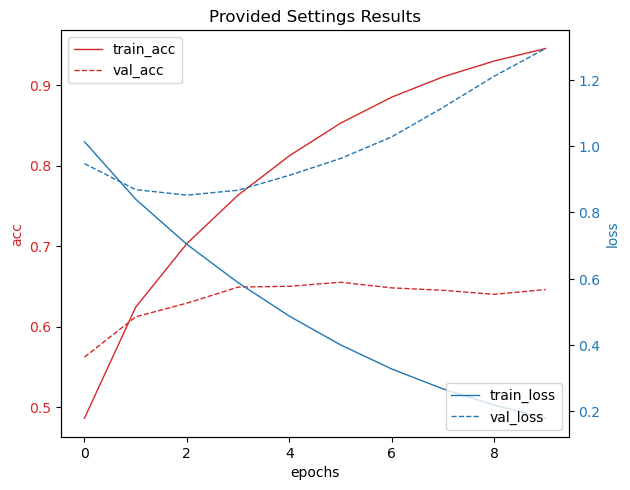

In [18]:
plot_over_training(results, "Provided Settings Results")

#### Performance variation based on hyper-parameter values

**Written 1:** (4 pts)
- For each mode of hyperparameter tuning (vocab size, embedding size, learning rate, reduce), report the training and validation losses and accuracies (in plotted curves). 
- Discuss the implications of each hyperparameter tuned.

Take the figure below as an example.

<!-- <img src="example.png" alt="drawing" style="width:400px;"/> -->
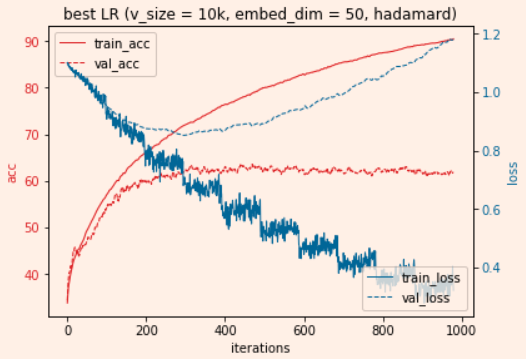

The following function may be useful to you to accomplish this, but you are also welcome to modify it or write your own plotting code.

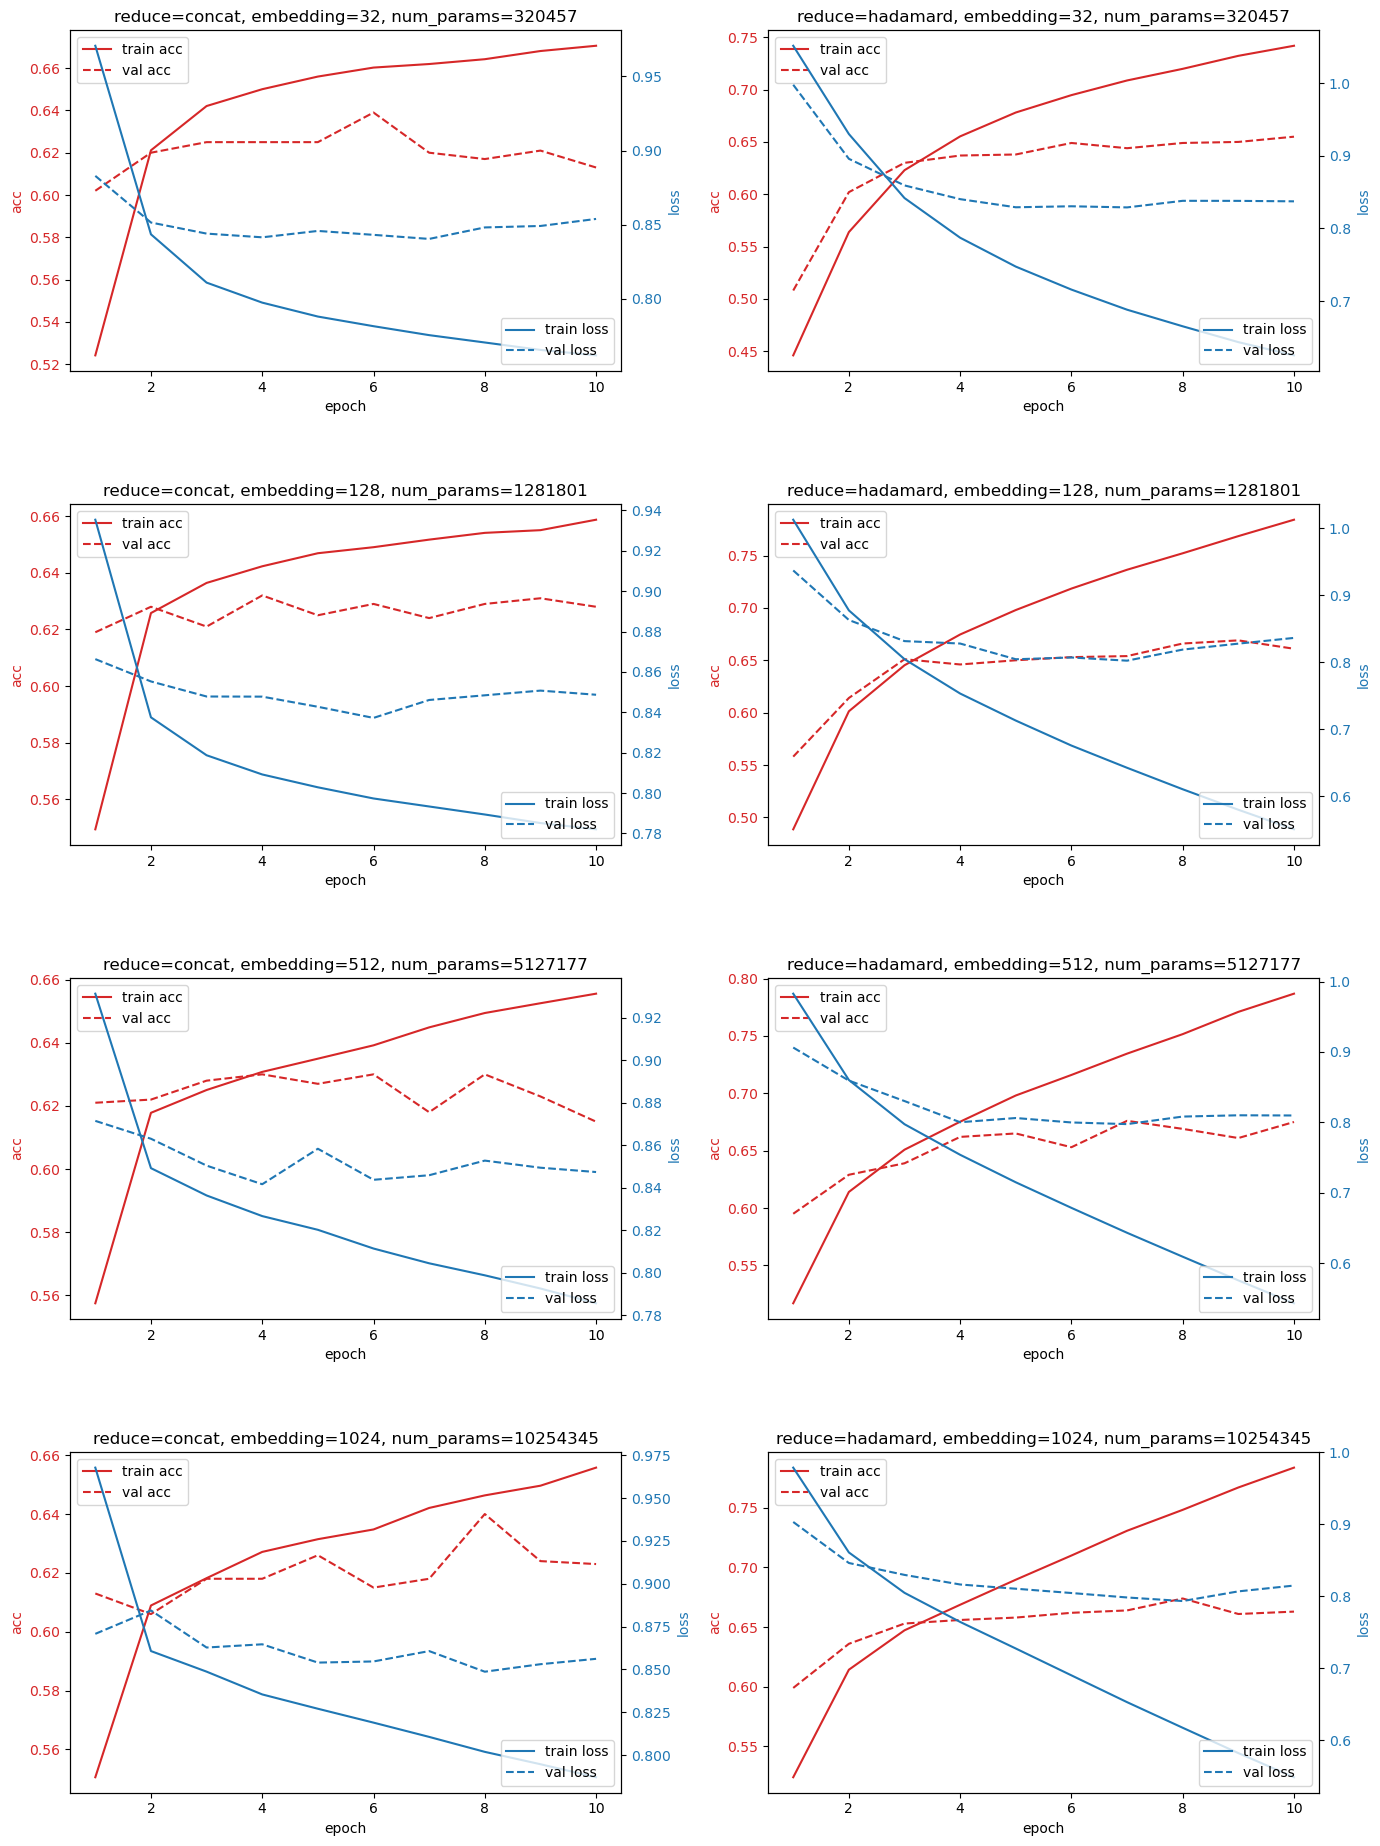

In [19]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
fig.tight_layout(pad=7.5)

axs2 = []

for i in range(axs.shape[0]):
    axs_row = []
    for j in range(axs.shape[1]):
        axs_row.append(axs[i, j].twinx())
    axs2.append(axs_row)
axs2 = np.array(axs2)


emb_dims = [32, 128, 512, 1024]
combinations = ["concat", "hadamard"]
num_epochs = 10
learning_rate = 0.01
best_model = None
best_acc = 0.0
best_params = {}

for i, emb_dim in enumerate(emb_dims):
    for j, reduce in enumerate(combinations):
        model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce).cuda()
        num_params = sum(p.numel() for p in model.parameters())
        
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        
        per_epoch_metrics = train(model, num_epochs)
        
        if max(per_epoch_metrics['val_accs']) > best_acc:
            best_model = model
            best_params['embed_dim'] = emb_dim
            best_params['combination'] = reduce
            best_acc = max(per_epoch_metrics['val_accs'])
        
        axs2[i, j].plot(range(1, num_epochs + 1), per_epoch_metrics['train_losses'], color='tab:blue', label='train loss')
        axs[i, j].plot(range(1, num_epochs + 1), per_epoch_metrics['train_accs'], color='tab:red', label='train acc')
        axs2[i, j].plot(range(1, num_epochs + 1), per_epoch_metrics['val_losses'], color='tab:blue', linestyle='dashed', label='val loss')
        axs[i, j].plot(range(1, num_epochs + 1), per_epoch_metrics['val_accs'], color='tab:red', linestyle='dashed', label='val acc')
        
        axs[i, j].set_xlabel('epoch')
        axs[i, j].set_ylabel('acc', color='tab:red')
        axs2[i, j].set_ylabel('loss', color='tab:blue')
        
        axs[i, j].tick_params(axis='y', labelcolor='tab:red')
        axs2[i, j].tick_params(axis='y', labelcolor='tab:blue')
        
        axs[i, j].legend(loc='upper left')
        axs2[i, j].legend(loc='lower right')
        axs[i, j].set_title('reduce={}, embedding={}, num_params={}'.format(reduce, emb_dim, num_params))
        

**Written 2:** (4 pts)   
Take your best model based on validation performace and report its validation accuracy:

In [20]:
best_model.eval()

val_loss = 0.0
val_acc = 0.0

wrong_output_data = []

for i, data in enumerate(valDataLoader):
    with torch.no_grad():
        hypos, len_hypos, prems, len_prems, labels = data
        hypos = hypos.cuda()
        len_hypos = len_hypos.cuda()
        prems = prems.cuda()
        len_prems = len_prems.cuda()
        labels = labels.cuda()
        outputs = best_model(hypos, len_hypos, prems, len_prems)
        _, predictions = torch.max(outputs, 1)
        if (predictions.item() != labels.item()):
            wrong_output_data.append((i, labels.item(), predictions.item()))
        fit = criterion(outputs, labels)
        val_loss += fit.item()
        val_acc += torch.sum(predictions == labels.data)
val_acc = (val_acc.float() / len(valDataLoader.dataset)).item()
print('Best Model Validation Accuracy = {}'.format(val_acc))

Best Model Validation Accuracy = 0.675000011920929


**Written 3:** (4 pts)

Highlight 3 correct and 3 incorrect predictions in this validation set. Describe why the model might have gotten the 3 incorrect predictions wrong.

In [21]:
num_examples = 3
label_dict = {0: 'neutral', 1: 'entails', 2: 'contradicts'}
for idx, label, pred in wrong_output_data[:num_examples]:
    print("Validation Sample #{}".format(idx))
    print(" ".join(prem_data_tokens_val[idx]))
    print(" ".join(hypo_data_tokens_val[idx]))
    print("Label = {}, Prediction = {}\n".format(label_dict[label], label_dict[pred]))

Validation Sample #5
two people are in a green forest
the forest is not dead
Label = entails, Prediction = contradicts

Validation Sample #7
two women one walking her dog the other pushing a stroller
there is a snowstorm
Label = contradicts, Prediction = entails

Validation Sample #13
man in white shirt and blue jeans looking to the side while walking down a busy sidewalk
man has a blue shirt on
Label = contradicts, Prediction = neutral



Considering we have such a simple model, it is not surprising that it has a very hard time capturing semantics in the sentences. Because the model overfits the training data quite significantly, it is most likely learning word patterns that are contained in the training samples and generalizing poorly in sentences that do not contain similar word patters.
For the first example, it is hard to infere that the forest being green means that is not dead, and unless the model encountered a similar example, it is going to have a hard time correlating the two. For the second example, it hard to infere what the model is actually detecting that might push it to classify the example as an entailment. Most likely, it is due to the model poor capability of extracting semantic meaning. Furthermore, the training data might contain very few examples with the words involved and it might be the case that most of those example are entailments, causing it to think that those words are mostly correlated with entailments. For the third example, it seems that the presence of word "blue" is sufficient to cause the model to misclassify the statement.